In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing import image
import keras
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy,Recall
import numpy as np

/var/folders/4q/2gx41lk113d_z9tsh7fj9_vh0000gn/T/ipykernel_90831/2983458988.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
# Fonction pour redimensionner, normaliser et prétraiter une image pour EfficientNetB0
def preprocess_image_efficientB0(img_path, target_size=(224, 224)):
    # Charger l'image depuis le chemin du fichier en couleur
    img = cv2.imread(img_path)
    # Redimensionnement de l'image à la taille cible pour EfficientNetB0
    img_resized = cv2.resize(img, target_size)
    # Prétraitement de l'image pour EfficientNetB0
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed

# Chemin vers les dossiers contenant les images saines et malades
pneumo_folder_path = "../../data/raw/datasets/Covid-19_MC_750_Dataset_All/Viral_Pneumonia" #0
normal_folder_path = "../../data/raw/datasets/Covid-19_MC_750_Dataset_All/Normal" #1
covid_folder_path = "../../data/raw/datasets/Covid-19_MC_750_Dataset_All/COVID" #2
# Classes:{0: 'Viral_Pneumonia', 1: 'Normal', 2: 'COVID'}
# Liste pour stocker les données d'images et les étiquettes
images_data = []
labels = []

# Parcours du dossier contenant les images Pneumonie Virale et les labelliser à 0
for filename in os.listdir(pneumo_folder_path):
    # Construire le chemin complet de l'image
    img_path = os.path.join(pneumo_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(0)

# Parcours du dossier contenant les images Normal et les labelliser à 1
for filename in os.listdir(normal_folder_path):
    img_path = os.path.join(normal_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(1)

# Parcours du dossier contenant les images COVID et les labelliser à 2
for filename in os.listdir(covid_folder_path):
    img_path = os.path.join(covid_folder_path, filename)
    # Prétraiter l'image et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_efficientB0(img_path))
    # Étiquettez les images 
    labels.append(2)

# Conversion des données
images_data = np.array(images_data)
labels = np.array(labels)

# Division des données en ensembles d'entraînement et de validation
x_train, x_val, y_train, y_val = train_test_split(images_data, labels, test_size=0.2, random_state=1234)

# Redivision des données d'entrainement en données d'entrainement et evaluation
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=1234)

num_classes = 3

batch=int(len(x_train)/10) # Batch size égal a 10% de la taille des données d'entrainements

print(f"batch size {batch}")

batch size 144


In [5]:
from keras import regularizers
from keras.regularizers import l1


# Définition de la fonction de construction de modèle pour Keras Tuner
# Keras Tuner: Learning rate, Couche Dense, Dropout et Droupout connect rate spécifique à EfficientNet, et learning rate pour la régularisation
def build_model(hp):
    # Hyperparamètres à rechercher
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log') # 1
    units = hp.Int('units', min_value=32, max_value=512, step=16) # 1
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05) # 1
    dropout_connect_rate = hp.Float('dropout_connect_rate', min_value=0.0, max_value=0.5, step=0.05) # 1
    l2_lambda = hp.Choice('l2_lambda', values=[1e-3, 1e-4, 1e-5]) # Hyperparamètre pour la régularisation L2
    
    # Chargement du modèle EfficientNetB0 pré-entraîné
    base_model = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=dropout_connect_rate)
    # Dégel de toutes les couches de convolution
    print(f"Nombre de couches base_model {len(base_model.layers)}")
    i=0
    for layer in base_model.layers:
        if isinstance(layer, Conv2D):
            layer.trainable = True  # Garde les couches BatchNormalization gelées pour stabiliser les activations
            i+=1
        else:
            layer.trainable = False  # Maintient les autres types de couches gelées  
    print(f"{i} Couches dégelées") 
    # Ajout des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = BatchNormalization()(x)
    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_lambda))(x)  # Utilisation de la régularisation L2
    
    # Ajouter plusieurs couches Dropout
    for _ in range(hp.Int('num_dropout_layers', min_value=1, max_value=3)):  # Limite le nombre de couches de dropout à 3 pour prévenir la sous-adaptation 3
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x) # Amélioration de la stabilité de l'apprentissage
    output = Dense(3, activation='softmax')(x)

    # Création du modèle final
    model = Model(inputs=base_model.input, outputs=output)

    # Compilation du modèle avec les hyperparamètres
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# Early Stopping basé sur la métrique de val accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,  
    restore_best_weights=True,  
    mode='max'  
)

# Configuration du tuner d'hyperparamètres RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Objectif d'optimiser la précision de validation
    max_trials=5,  
    executions_per_trial=1, 
    directory='EfficientNetB0_3C_750_dir',
    project_name='EfficientNetB0_3C_750_pj'
)

tuner.search(x_train, y_train, epochs=100, batch_size=batch, validation_data=(x_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 46m 15s]
val_accuracy: 0.9755555391311646

Best val_accuracy So Far: 0.9755555391311646
Total elapsed time: 03h 48m 06s


In [6]:
'''
RUN BASE SUR VAL_ACCURACY
Trial 2 Complete [00h 41m 06s]
val_accuracy: 0.9755555391311646

Best val_accuracy So Far: 0.9755555391311646
Total elapsed time: 01h 18m 04s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
4.0059e-05        |0.0005694         |learning_rate
400               |192               |units
0.1               |0.3               |dropout_rate
0.25              |0.25              |dropout_connect_rate
0.0001            |0.001             |l2_lambda
1                 |1                 |num_dropout_layers

Trial 3 Complete [00h 43m 35s]
val_accuracy: 0.9644444584846497

Best val_accuracy So Far: 0.9755555391311646
Total elapsed time: 02h 01m 39s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
2.6925e-05        |0.0005694         |learning_rate
192               |192               |units
0.05              |0.3               |dropout_rate
0.3               |0.25              |dropout_connect_rate
0.001             |0.001             |l2_lambda
1                 |1                 |num_dropout_layers

Trial 4 Complete [01h 00m 11s]
val_accuracy: 0.9733333587646484

Best val_accuracy So Far: 0.9755555391311646
Total elapsed time: 03h 01m 50s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3.3598e-05        |0.0005694         |learning_rate
176               |192               |units
0.3               |0.3               |dropout_rate
0.25              |0.25              |dropout_connect_rate
0.001             |0.001             |l2_lambda
1                 |1                 |num_dropout_layers
Trial 5 Complete [00h 46m 15s]
val_accuracy: 0.9755555391311646

Best val_accuracy So Far: 0.9755555391311646
Total elapsed time: 03h 48m 06s
'''

'\nRUN BASE SUR VAL_ACCURACY\nTrial 2 Complete [00h 41m 06s]\nval_accuracy: 0.9755555391311646\n\nBest val_accuracy So Far: 0.9755555391311646\nTotal elapsed time: 01h 18m 04s\n\nSearch: Running Trial #3\n\nValue             |Best Value So Far |Hyperparameter\n4.0059e-05        |0.0005694         |learning_rate\n400               |192               |units\n0.1               |0.3               |dropout_rate\n0.25              |0.25              |dropout_connect_rate\n0.0001            |0.001             |l2_lambda\n1                 |1                 |num_dropout_layers\n\nTrial 3 Complete [00h 43m 35s]\nval_accuracy: 0.9644444584846497\n\nBest val_accuracy So Far: 0.9755555391311646\nTotal elapsed time: 02h 01m 39s\n\nSearch: Running Trial #4\n\nValue             |Best Value So Far |Hyperparameter\n2.6925e-05        |0.0005694         |learning_rate\n192               |192               |units\n0.05              |0.3               |dropout_rate\n0.3               |0.25              |d

In [7]:
# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]

# Construire le modèle avec les meilleurs hyperparamètres trouvés
best_model = tuner.hypermodel.build(best_hp)

Nombre de couches base_model 238
65 Couches dégelées


In [8]:
print(best_hp.values)

{'learning_rate': 0.0005694007711882117, 'units': 192, 'dropout_rate': 0.30000000000000004, 'dropout_connect_rate': 0.25, 'l2_lambda': 0.001, 'num_dropout_layers': 1}


In [38]:
# {'learning_rate': 0.0005694007711882117, 'units': 192, 'dropout_rate': 0.30000000000000004, 'dropout_connect_rate': 0.25, 'l2_lambda': 0.001, 'num_dropout_layers': 1}

In [9]:
import dill as pickle

# Sauvegarder l'objet random search dans un fichier
with open('EfficientNetB0_3C_750_randomsearch.pkl', 'wb') as file:
    pickle.dump(tuner, file)
#import pickle

# Charger l'objet random search depuis le fichier
with open('EfficientNetB0_3C_750_randomsearch.pkl', 'rb') as file:
    random_search_loaded = pickle.load(file)


In [10]:
# Entraîner le modèle avec les meilleurs hyperparamètres trouvés
history = best_model.fit(x_train, y_train,
                         epochs=100,batch_size=batch,
                         validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.6683 - loss: 1.1810 - val_accuracy: 0.5156 - val_loss: 1.3223
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9091 - loss: 0.5607 - val_accuracy: 0.7978 - val_loss: 0.8347
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9358 - loss: 0.5126 - val_accuracy: 0.8600 - val_loss: 0.6811
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9733 - loss: 0.4137 - val_accuracy: 0.8889 - val_loss: 0.5969
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9849 - loss: 0.3781 - val_accuracy: 0.8889 - val_loss: 0.5966
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9782 - loss: 0.3702 - val_accuracy: 0.9400 - val_loss: 0.4879
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9915 - loss: 0.3435 - val_accuracy: 0.9200 - val_loss: 0.5143
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9950 - loss: 0.3312 - val_accuracy: 0.9111 - v

In [ ]:
## Metriques

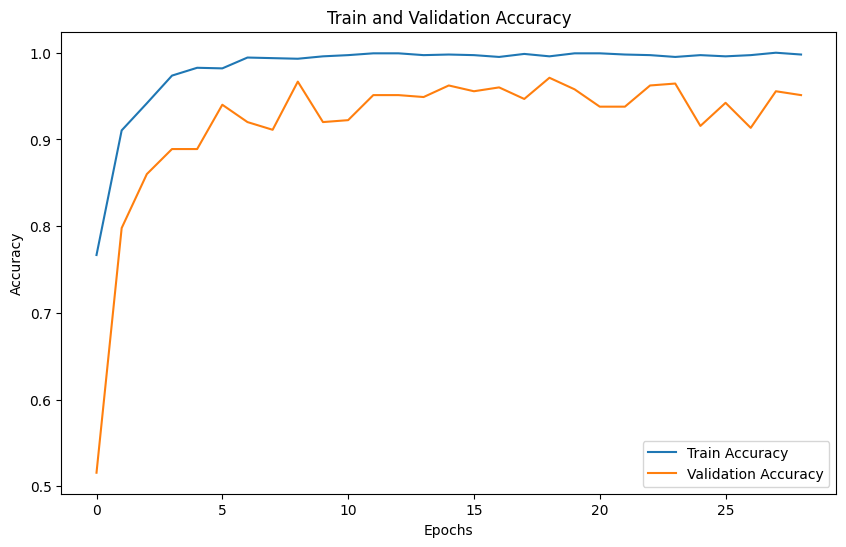

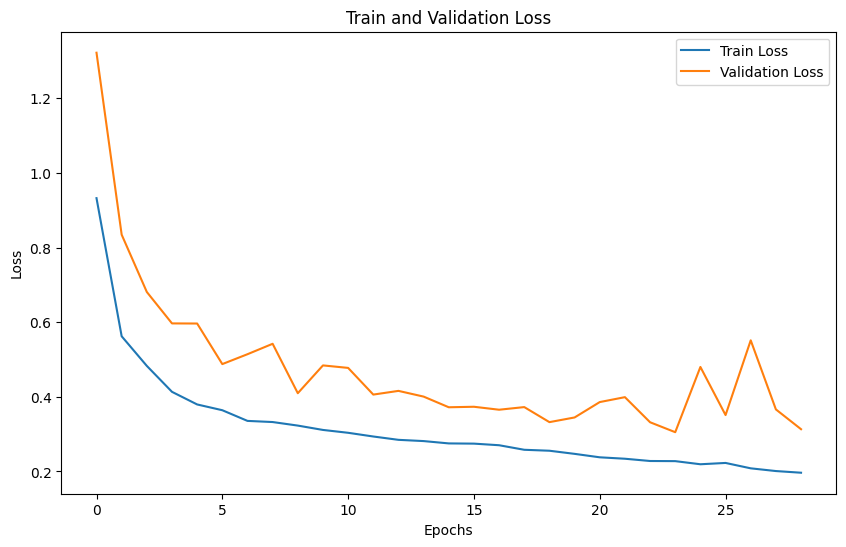

In [24]:
import matplotlib.pyplot as plt

# Afficher et sauvegarder l'accuracy en fonction du nombre d'époques
plt.figure(figsize=(10, 6))  # Optionnel: Définir la taille de l'image
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.savefig('EfficientNetB0_3C_750_history_accuracy.png')  # Sauvegarde de l'image avant plt.show()
plt.show()

# Afficher et sauvegarder la perte en fonction du nombre d'époques
plt.figure(figsize=(10, 6))  # Optionnel: Définir la taille de l'image
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.savefig('EfficientNetB0_3C_750_history_loss.png')  # Sauvegarde de l'image avant plt.show()
plt.show()


In [12]:
import pickle
import json

# Enregistrer le modèle
best_model.save('../../data/processed/models/notebooks/EfficientNetB0_3C_750_model.keras')
best_model.save('../../data/processed/models/notebooks/EfficientNetB0_3C_750_model.h5')

# Enregistrer l'historique
with open('../../data/processed/models/notebooks/EfficientNetB0_3C_750_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Enregistrer les métriques dans un fichier JSON
metrics_dict = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

with open('../../data/processed/models/notebooks/EfficientNetB0_3C_750_metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file)

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Faire des prédictions sur l'ensemble de données de validation
predictions = best_model.predict(x_val)
print(f"predictions {predictions}")
# Conversion des prédictions en classes (classification multiple)
predicted_classes = np.argmax(predictions,axis=1)
print(f"predicted_classes {predicted_classes}")
print(f"y_val {y_val}")
# Calculer l'accuracy
accuracy = np.mean(predicted_classes == y_val)

print("Val Accuracy:", accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step
predictions [[1.8914872e-04 9.9952906e-01 2.8181006e-04]
 [9.9857253e-01 8.6850236e-04 5.5902958e-04]
 [9.9948639e-01 2.6955907e-04 2.4419167e-04]
 ...
 [2.7009926e-04 9.9946934e-01 2.6056223e-04]
 [3.3510581e-03 1.5454139e-03 9.9510348e-01]
 [3.9748821e-04 3.8532304e-04 9.9921715e-01]]
predicted_classes [1 0 0 0 0 1 0 2 1 1 1 1 1 0 1 2 0 0 0 0 0 2 2 0 1 1 1 2 0 1 1 0 0 1 1 2 0
 0 1 1 2 1 0 1 0 2 1 1 1 0 0 0 0 1 1 0 0 1 2 1 1 2 1 2 2 2 1 1 2 2 2 2 2 1
 2 1 0 1 2 0 0 0 2 2 0 2 2 2 1 2 0 0 1 0 2 1 0 2 0 0 2 2 2 0 1 0 2 1 0 1 0
 1 1 0 2 1 0 2 0 1 1 0 2 1 1 2 1 1 2 0 1 1 1 2 2 1 0 0 1 2 1 2 0 0 2 1 0 0
 2 2 0 0 0 2 1 2 0 2 2 0 0 0 2 0 1 0 1 1 2 2 0 0 2 2 0 1 0 2 1 2 0 0 0 2 0
 1 1 0 1 0 1 0 1 2 1 0 1 0 1 0 0 1 1 2 2 0 2 0 1 1 0 1 1 2 2 0 1 2 2 0 0 1
 0 0 0 1 1 0 2 2 2 0 0 1 1 2 2 1 0 2 2 1 1 2 0 0 2 0 2 1 1 1 2 0 0 0 0 1 1
 2 0 1 0 0 2 2 0 0 0 0 1 0 1 0 2 2 2 1 2 1 1 0 1 1 0 1 1 0 1 2 0 1 1 0 2 1
 2 0 1 1 0 2 2 2 0 2 2 0 1 0 0 0 0 1 1 0 1 2 2 1 2 0

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Prédictions sur l'ensemble de données de test
eval_predictions = best_model.predict(x_eval)
print(f"predictions {predictions}")
# Convertir les prédictions en classes (Classification multiple)
eval_predicted_classes = np.argmax(eval_predictions,axis=1)
print(f"eval_predicted_classes {eval_predicted_classes}")
print(f"y_eval {y_eval}")
#y_eval_classes = np.argmax(y_eval)
#print(f"y_eval_classes {y_eval_classes}")
# Calculer l'accuracy
eval_accuracy = np.mean(eval_predicted_classes == y_eval)

print("EVAL Accuracy:", eval_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 710ms/step
predictions [[1.8914872e-04 9.9952906e-01 2.8181006e-04]
 [9.9857253e-01 8.6850236e-04 5.5902958e-04]
 [9.9948639e-01 2.6955907e-04 2.4419167e-04]
 ...
 [2.7009926e-04 9.9946934e-01 2.6056223e-04]
 [3.3510581e-03 1.5454139e-03 9.9510348e-01]
 [3.9748821e-04 3.8532304e-04 9.9921715e-01]]
eval_predicted_classes [0 1 2 0 1 1 2 0 2 2 1 0 2 2 2 1 0 0 0 2 0 2 2 2 0 0 0 2 0 2 1 2 2 0 1 1 0
 1 1 1 1 0 1 1 0 0 0 0 2 0 2 2 2 1 0 2 2 0 1 1 0 2 1 1 1 0 2 1 2 0 0 1 2 0
 1 0 0 0 1 2 2 1 0 1 0 2 0 2 1 0 0 0 0 0 2 1 1 2 1 2 1 0 2 1 2 1 0 0 1 0 2
 2 0 2 1 0 2 0 2 0 1 2 0 0 1 1 1 0 2 0 0 0 2 2 0 0 0 2 2 2 0 0 2 1 2 2 0 2
 0 0 0 2 2 1 0 0 2 1 2 2 0 1 2 0 1 1 2 0 0 1 2 1 1 2 0 1 2 0 1 0 2 2 2 1 0
 1 1 2 0 1 0 2 2 2 2 1 1 0 1 2 0 2 2 0 0 1 2 2 1 1 2 1 2 1 0 1 1 2 0 1 0 0
 2 2 2 2 0 2 0 1 0 2 1 0 1 1 2 1 2 1 2 1 0 1 2 1 2 2 2 2 0 1 2 0 1 1 1 2 1
 0 0 0 2 0 2 1 1 0 0 0 1 0 1 0 1 2 1 2 1 2 2 2 2 0 1 2 1 2 2 1 2 1 1 0 2 0
 2 0 0 2 2 0 1 1 0 2 0 1 0 1 0 2 0 1 2 2 1 0 0 2

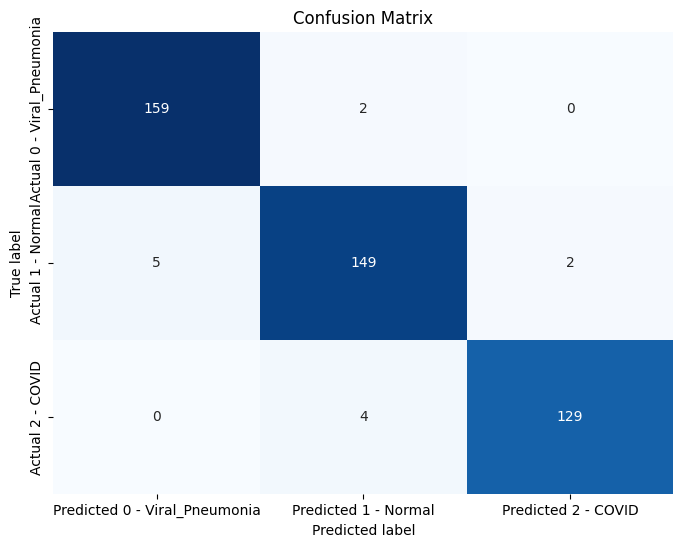

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_val, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0 - Viral_Pneumonia', 'Predicted 1 - Normal', 'Predicted 2 - COVID'],
            yticklabels=['Actual 0 - Viral_Pneumonia', 'Actual 1 - Normal', 'Actual 2 - COVID'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Sauvegarder l'image de la matrice de confusion
plt.savefig('EfficientNetB0_3C_750_confusion_matrix.png')  # Sauvegarde de l'image avant plt.show()

plt.show()

In [16]:
## Classification Report
from sklearn.metrics import classification_report
class_dic={0: 'Viral_Pneumonia', 1: 'Lung_Opacity', 2: 'Normal', 3: 'COVID'}
report = classification_report(y_val, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       161
           1       0.96      0.96      0.96       156
           2       0.98      0.97      0.98       133

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



GRAD-CAM

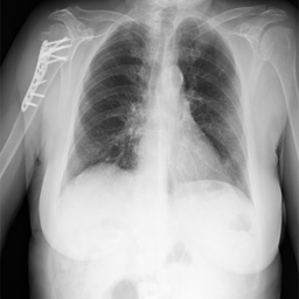

In [17]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "top_conv"

# The local path to our target image
img_path =('./test_images/COVID-231.png')
#{0: 'Viral_Pneumonia', 1: 'Lung_Opacity', 2: 'Normal', 3: 'COVID'}
display(Image(img_path))

In [18]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

(1, 224, 224, 3)
------------
(224, 224, 3)
[[[[-0.9137255  -0.9137255  -0.9137255 ]
   [-0.96862745 -0.96862745 -0.96862745]
   [-0.9607843  -0.9607843  -0.9607843 ]
   ...
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.92941177 -0.92941177 -0.92941177]
   [-0.88235295 -0.88235295 -0.88235295]]

  [[-0.90588236 -0.90588236 -0.90588236]
   [-0.96862745 -0.96862745 -0.96862745]
   [-0.9607843  -0.9607843  -0.9607843 ]
   ...
   [-0.9137255  -0.9137255  -0.9137255 ]
   [-0.9372549  -0.9372549  -0.9372549 ]
   [-0.88235295 -0.88235295 -0.88235295]]

  [[-0.90588236 -0.90588236 -0.90588236]
   [-0.96862745 -0.96862745 -0.96862745]
   [-0.9607843  -0.9607843  -0.9607843 ]
   ...
   [-0.92156863 -0.92156863 -0.92156863]
   [-0.9372549  -0.9372549  -0.9372549 ]
   [-0.88235295 -0.88235295 -0.88235295]]

  ...

  [[-0.92156863 -0.92156863 -0.92156863]
   [-0.9764706  -0.9764706  -0.9764706 ]
   [-0.9764706  -0.9764706  -0.9764706 ]
   ...
   [-0.92941177 -0.92941177 -0.92941177]
   [-0.937254

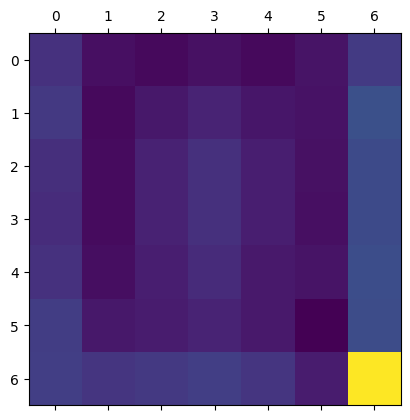

In [19]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print(img_array.shape)
print("------------")
img_array2=preprocess_image_efficientB0(img_path)
print(img_array2.shape)
img_array2_resh=img_array2.reshape((1, 224, 224, 3))
print(img_array2_resh)
# Make model
model = best_model

# Remove last layer's softmax
model.layers[-1].activation = None
preds = model.predict(img_array2_resh)
print(f"Preds {preds}")
preds_classe = np.argmax(preds,axis=1)
print(f"preds_classe {preds_classe}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array2_resh, model, last_conv_layer_name)

########
# Display heatmap
plt.matshow(heatmap)
plt.show()

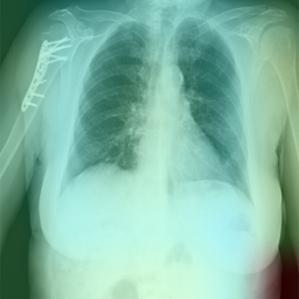

In [20]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)